# One-way ANOVA

Imagine you have three groups, and you want to do a one-level ANOVA to test for
overall differences across the groups.

The general technique for a permutation test is:

* You decide on your metric
* You get your metric for the actual data - observed metric
* You permute your data and take the same metric from the permuted data, and
  repeat many times - fake metrics
* You compare your observed metric to your fake metrics, to see how unusual it
  is.

For a two-sample permutation test, your metric is the difference in the two
sample means.

For a three sample version of the test — we need a metric that will be big
where there are big differences between the three groups, and small when there
are small differences.

Let us reflect on what what we want from the metric.  It should be a single
number to summarize all the values from the groups. It should be be large for
big differences between the means for the various groups.  It should be larger
when more observations are in the groups with large difference in means.

Consider the following metric.  We will soon see this is the metric that the F-test uses.

* Get the sample means for each of the three groups A, B, C, to give `mean_a`,
  `mean_b`, `mean_c`
* Get the mean across all the observations regardless of group
  (`mean_overall`)
* Subtract `mean_overall` from each of `mean_a`, `mean_b`, `mean_c` to give
  `mean_a_diff`, `mean_b_diff`, `mean_c_diff`.
* We are interested in positive as well as negative differences, so we do not
  want to add these mean differences, otherwise the positive and negative means
  differences will cancel out. So we next square the differences to give:
  `sq_mean_a_diff`, `sq_mean_b_diff`, `sq_mean_c_diff`.
* We want larger groups to have greater weight than small groups.  Call the
  number in groups A, B, and C `n_a`, `n_b`, `n_c`. To weight the squared mean
  differences we multiply each square mean difference by the number in each
  group: `sq_mean_a_diff * n_a`, `sq_mean_b_diff * n_b`, `sq_mean_c_diff *
  n_b`, to give `nsq_mean_a_diff`, `nsq_mean_b_diff`, `n_sq_mean_c_diff`.
*   Finally, we add up the group `nsq` scores to give our metric:

    ```
    our_metric = nsq_mean_a_diff + nsq_mean_b_diff + nsq_mean_c_diff
    ```

We will call this the SNSQGMD metric (Sum of N times SQuared Group Mean
Difference).

SNSQGMD will be large and positive when the individual groups have different
means from each other and small when the means for the groups are pretty
similar to each other, and therefore, to the overall mean.  It will be larger
when larger groups have means with bigger deviations from the overall mean.

To follow the recipe above, we calculate SNSQGMD for the actual groups A, B, C.
Permute the group labels to give random groups A, B, C, and recalculate the
metric.   See whether SNSQGMD in the real data is unusual in the distribution of
the same metric for the permuted groups.

This is the permutation equivalent of the one-way ANOVA.   The one-way ANOVA
just uses some assumptions from the normal distribution to estimate the spread
in the random distribution of SNSQGMD, instead of using permutation to calculate
the random distribution.


## An example

Dataset from <https://dasl.datadescription.com/datafile/contrast-baths>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## The example dataset, ready for analysis

The data corresponds to [this
paper](https://pubmed.ncbi.nlm.nih.gov/19375278/).

From the abstract:

> Methods: Study participants were randomly assigned to one of three treatment
> group protocols--contrast baths with exercise, contrast baths without
> exercise, and an exercise-only control treatment group. Study participants
> were evaluated with hand volumetry, before and after treatment at two
> different data collection periods-pre- and postoperatively.

It is not clear what data we have, but they may be change scores before and
after treatment, for the pre-operative group.

Notice we have three treatment groups, the "Bath" group, the "Bath+Exercise"
group and the "Exercise" group.

In [2]:
# Read the raw dataset
baths = pd.read_csv('contrast-baths.txt', sep='\t')
baths.head()

,Treatment,Hand Vol Chg
0,Bath,10
1,Exercise,0
2,Bath,10
3,Bath,5
4,Bath,


We need to do some processing go analyze the data.  Although the second column has the numerical values we are interested in, Pandas has read both columns as Python strings ("objects"):

In [3]:
baths.dtypes

Treatment       object
Hand Vol Chg    object
dtype: object

Investigating, the missing data here are given by a single space character.
Fix that, by replacing single spaces with empty strings. Then we convert all
the "Hand Vol Chg" values to numbers.

In [4]:
baths['Hand Vol Chg'] = baths['Hand Vol Chg'].replace(' ', '')
baths['Hand Vol Chg'] = pd.to_numeric(baths['Hand Vol Chg'])
baths.head()

,Treatment,Hand Vol Chg
0,Bath,10.0
1,Exercise,0.0
2,Bath,10.0
3,Bath,5.0
4,Bath,NaN


For simplicity, drop the missing `NaN` values:

In [5]:
clean_baths = baths.dropna()
clean_baths.head()

,Treatment,Hand Vol Chg
0,Bath,10.0
1,Exercise,0.0
2,Bath,10.0
3,Bath,5.0
5,Exercise,4.0


We are now ready to do the analysis.

## Means by group

Here are the data, plotted by group.

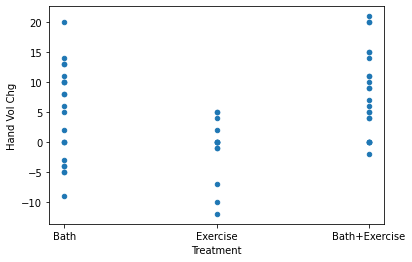

In [6]:
clean_baths.plot.scatter('Treatment', 'Hand Vol Chg');

These are the means for each of the three groups.

In [7]:
group_means = clean_baths.groupby('Treatment').mean()
group_means

,Hand Vol Chg
Treatment,
Bath,4.545455
Bath+Exercise,8.000000
Exercise,-1.071429


These are the number of observations per group:

In [8]:
group_ns = clean_baths.groupby('Treatment').count()
group_ns

,Hand Vol Chg
Treatment,
Bath,22
Bath+Exercise,23
Exercise,14


Here is the overall mean, ignoring the group membership:

In [9]:
overall_mean = np.mean(clean_baths['Hand Vol Chg'])
overall_mean

4.559322033898305

The next plot shows the data, the group means, and the overall mean:

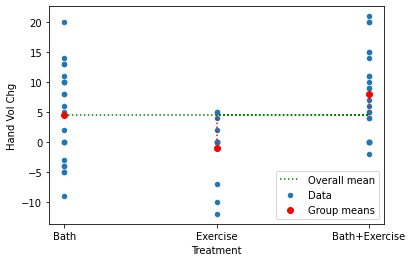

In [10]:
clean_baths.plot.scatter('Treatment', 'Hand Vol Chg',
                         label='Data')
plt.scatter(group_means.index, np.array(group_means), color='red',
            label='Group means')
# A dashed line at the overall mean.
plt.plot(group_means.index,
         [overall_mean, overall_mean, overall_mean],
         ':', color='green',
         label='Overall mean')
# A dashed line between each group mean and the overall mean.
for group in group_means.index:
    xs = [group, group]
    ys = [float(group_means.loc[group]), overall_mean]
    plt.plot(xs, ys, ':', color='red')
plt.legend();

Notice the red dashed lines between the group means and the overall mean. We
designed our SNSQGMD metric to be large when the sum of the squared lengths of
these lines are large.  The N in  SNSQGMD reminds us we multiply each squared
length by the number in the group, to give more weight to large groups.

To calculate SNSQGMD we get the Group Mean Difference.

In [11]:
gmd = group_means - overall_mean
gmd

,Hand Vol Chg
Treatment,
Bath,-0.013867
Bath+Exercise,3.440678
Exercise,-5.630751


We square these differences:

In [12]:
sq_gmd = gmd ** 2
sq_gmd

,Hand Vol Chg
Treatment,
Bath,0.000192
Bath+Exercise,11.838265
Exercise,31.705352


We want to give more weight to groups with more members, so we multiply each squared difference by the number in the group:

In [13]:
n_sq_gmd = sq_gmd * group_ns
n_sq_gmd

,Hand Vol Chg
Treatment,
Bath,0.004231
Bath+Exercise,272.280092
Exercise,443.874933


Finally, we add up these weighted squares to get the final metric:

In [14]:
observed_sn_sq_gmd = np.sum(n_sq_gmd)
observed_sn_sq_gmd

Hand Vol Chg    716.159256
dtype: float64

This is our metric.  To make this a bit clearer, we put the calculation of our
metric into its own function so we can re-use it on different data frames.

In [15]:
def get_sn_sq_gmd(df, group_col, val_col):
    overall_mean = np.mean(df[val_col])
    grouped = df.groupby(group_col)[val_col]
    sq_gmd = (grouped.mean() - overall_mean) ** 2
    return np.sum(sq_gmd * grouped.count())

Check that we get the same answer from the function as we did with the step-by-step calculation:

In [16]:
get_sn_sq_gmd(clean_baths, 'Treatment', 'Hand Vol Chg')

716.159255998239

Next we consider a single trial in our ideal, null, fake world.  We do this by
making a copy of the data frame, and then permuting the Treatment labels, so
the association between the Treatment and the change values is random.

In [17]:
fake_data = clean_baths.copy()
# Permute the treatment labels
fake_data['Treatment'] = np.random.permutation(fake_data['Treatment'])
fake_data.head()

,Treatment,Hand Vol Chg
0,Exercise,10.0
1,Bath,0.0
2,Bath+Exercise,10.0
3,Bath,5.0
5,Exercise,4.0


Next we calculate our metric step by step.

In [18]:
fake_grouped = fake_data.groupby('Treatment')['Hand Vol Chg']
# Notice that the overall_mean cannot change because we did not
# change these values.
fake_sq_gmd = (fake_grouped.mean() - overall_mean) ** 2
fake_sn_sq_gmd = np.sum(fake_sq_gmd * fake_grouped.count())
fake_sn_sq_gmd

98.54745475600302

We can also use our function to do that calculation, to get the same answer:

In [19]:
get_sn_sq_gmd(fake_data, 'Treatment', 'Hand Vol Chg')

98.54745475600302

Now we are ready to do our simulation.  We do 10000 trials, making a new random
association, and recalculating our sum of squares metric.

In [20]:
n_iters = 10000
fake_sn_sq_gmds = np.zeros(n_iters)
for i in np.arange(n_iters):
    # Make sample from null world.
    fake_data['Treatment'] = np.random.permutation(fake_data['Treatment'])
    # Calculate corresponding metric.
    fake_sn_sq_gmds[i] = get_sn_sq_gmd(fake_data, 'Treatment', 'Hand Vol Chg')

Of course, because these are sums of squares, they must all be positive.

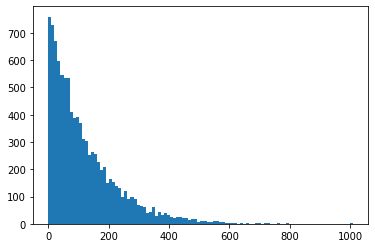

In [21]:
plt.hist(fake_sn_sq_gmds, bins=100);

How does our observed sum of squares metric compare to the distribution of fake
sum of square metrics?

In [22]:
p = np.count_nonzero(fake_sn_sq_gmds >= float(observed_sn_sq_gmd)) / n_iters
p

0.0015

The p value tells us that this observed metric is very unlikely to have come
about in a random world.


## Comparing to standard one-way ANOVA F tests

Here we do the standard F-test calculations to show that we get a similar p
value to the permutation version above.  Here is the Statsmodels
implementation of the one-way F test:

In [23]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# The Q() in the formula is just to allow spaces in the variable name.
mod = smf.ols('Q("Hand Vol Chg") ~ Treatment', data=clean_baths).fit()

sm.stats.anova_lm(mod, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
Treatment,2.0,716.159256,358.079628,7.4148,0.001391
Residual,56.0,2704.383117,48.292556,NaN,NaN


Here is the same calculation in Scipy:

In [24]:
from scipy.stats import f_oneway

In [25]:
# Get the values from the individual groups.
treatment = clean_baths['Treatment']
change = clean_baths['Hand Vol Chg']
bath = change[treatment == 'Bath']
both = change[treatment == 'Bath+Exercise']
exercise = change[treatment == 'Exercise']

Do the F-test:

In [26]:
f_result = f_oneway(bath, both, exercise)
f_result

F_onewayResult(statistic=7.414799716344096, pvalue=0.0013907554044090167)

## The F statistic and the SNSQGMD metric

In this section, we go into more detail about the calculation of the F value that you see above, in the F tests.  Here is the calculated F statistic from Scipy.  You have seen we got the same value from Statsmodels.

In [27]:
F_stat = f_result.statistic
F_stat

7.414799716344096

This section goes through the calculation of the F statistic from the SNSQGMD metric.  This is the value we got for that metric:

In [28]:
observed_sn_sq_gmd

Hand Vol Chg    716.159256
dtype: float64

You can get the F statistic above by dividing the SNSQGMD metric by a scaled estimate of the variation still present in the data.

The variation still present in the data are the remaining distances between the
data (in the plot above) and their corresponding group means.  Call these
remaining distances the "residuals".

Here are the group means:

In [29]:
group_means

,Hand Vol Chg
Treatment,
Bath,4.545455
Bath+Exercise,8.000000
Exercise,-1.071429


We are going to put the group means into their own column in the original data frame, in order to subtract them from the individual values.  First we make a new copy of the group means, but renaming the value column for later.

In [30]:
gms_renamed = group_means.rename(columns={"Hand Vol Chg": "vol_chg_mean"})
gms_renamed

,vol_chg_mean
Treatment,
Bath,4.545455
Bath+Exercise,8.000000
Exercise,-1.071429


Next we merge this group means data frame into the original table, to give every row its corresponding group mean.

In [31]:
baths_and_means = clean_baths.merge(gms_renamed, on='Treatment')
baths_and_means.head()

,Treatment,Hand Vol Chg,vol_chg_mean
0,Bath,10.0,4.545455
1,Bath,10.0,4.545455
2,Bath,5.0,4.545455
3,Bath,-4.0,4.545455
4,Bath,8.0,4.545455


Now we can calculate the residuals by subtracting the corresponding group mean from each hand volume change value.

In [32]:
baths_and_means['resid'] = (baths_and_means['Hand Vol Chg'] -
                            baths_and_means['vol_chg_mean'])
baths_and_means.head()

,Treatment,Hand Vol Chg,vol_chg_mean,resid
0,Bath,10.0,4.545455,5.454545
1,Bath,10.0,4.545455,5.454545
2,Bath,5.0,4.545455,0.454545
3,Bath,-4.0,4.545455,-8.545455
4,Bath,8.0,4.545455,3.454545


Next we give a number (metric) to the residuals by squaring (to remove the signs) and adding:

In [33]:
ssq_resid_groups = np.sum((baths_and_means['resid']) ** 2)
ssq_resid_groups

2704.3831168831166

The F-statistic results from dividing this measure of remaining variation
into the SNSQGMD metric, with some scaling.  The scaling comes from the number of observations, and the number of groups.

In [34]:
n_obs = len(baths_and_means)
n_groups = len(group_means)

Here is the full calculation of the F-statistic. Notice that it is exactly the same as we got from Scipy and Statsmodels.

In [35]:
# Calculate of the F value by scaling and dividing by residual variation
# metric.
df_groups = n_groups - 1  # Degrees of freedom for groups.
df_error = n_obs - n_groups  # Degrees of freedom for residuals.
# The F statistic
(observed_sn_sq_gmd / df_groups) / (ssq_resid_groups / df_error)

Hand Vol Chg    7.4148
dtype: float64

Scaling and dividing by the residual variation gives a value that we can reason
about with some standard mathematics, as long as we are prepared to assume that
the distribution of the values is normal.  Specifically, with those assumptions, we can get a p value by comparing the observed F value to a standard F distribution with the same "degrees of freedom".  These are the `df_groups` and `df_error` values above.

As you have seen, the permutation estimate gives a very similar answer.  We would argue that it is also a lot easier to explain.


## F tests in terms of explained variation

You will often see explanations of the F-value in terms of the amount of
variation explained by the overall mean, compared to the amount of variation
explained with the individual group means.  In fact, this "variance" way of
thinking is what gave the test the name ANOVA (Analysis of Variance).

The explained variation path (literally) adds up to the same thing as the
SNSQGMD metric version of the F statistic above.  This section goes through the
explained variation way of thinking of the F statistic, and shows that it
gives the same value for the SNSQGMD metric.

The "variance" way of thinking about the F looks at the sum of squared
"residual" variation in two situations.  First we get the residual variation
when we use subtract the group means.  We already have this from the F test calculation above.  As a reminder, we repeat the calculation here:

In [36]:
ssq_resid_groups = np.sum((baths_and_means['resid']) ** 2)
ssq_resid_groups

2704.3831168831166

This is the sum of squared remaining variation when using the group means.

We compare this to the squared remaining variation when just using the overall mean.  Here is that calculation.

In [37]:
# Sum of squared residuals using overall mean
# Subtract the overall mean from the original values to get residuals.
resid_overall = clean_baths['Hand Vol Chg'] - overall_mean
# Square and sum the residuals to get the squared variation from overall mean.
ssq_resid_overall = np.sum(resid_overall ** 2)
ssq_resid_overall

3420.542372881356

The variance way of thinking says that we should be particularly interested in our group means, when using them does a very good job of reducing the variation.  This will happen when the group values are closer to their individual group means, than they are to the overall mean.  In that case, `ssq_resid_groups` will be much lower than `ssq_resid_overall`, so we will get a fairly high value for `ssq_resid_overall - ssq_resid_groups`:

In [38]:
ssq_resid_overall - ssq_resid_groups

716.1592559982396

Oh - wait - that's *exactly* the same as the SNSQGMD metric we were already using!

In [39]:
observed_sn_sq_gmd

Hand Vol Chg    716.159256
dtype: float64

This striking fact is to do with the algebra of adding squared deviations from means.  The equivalence gives us the two different ways of thinking of the SNSQGMD metric.  It can be either:

* A measure of how far the sample means are from the overall mean, OR
* A measure of how much "unexplained" variation is left when *not* using
  the sample means.

In this second "unexplained variance" interpretation, we think of the F test
calculation as being a ratio of the unexplained variance to the variance
remaining when we do use the sample means.  If the sample means explain a lot of variation, then the top half of the F statistic will be large, and the bottom half will be small, giving a large F value.